# Dense Neural Network

* Here we are dealing with the most basic neural network. 
The network contains two hidden Dense Neural Networks.

* We use Standard Scaling for input(X) and Mean-Max Scaling for output(Y). Tanh is used as the output activation function. 

* 12th label parameter (one of the Dihedral angles) had some issues which is fixed. 

* IQR method is used to remove outliers.


# Data Augmentation using FFT
I was experimenting with the data by taking its fourier transform to see if it captures the labels better than its original counterpart. 

In [2]:
import numpy as np # linear algebra
from scipy import signal
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import time
%matplotlib inline
from sklearn.model_selection import train_test_split
import tensorflow
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPool1D, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler

Using TensorFlow backend.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
X = np.load('/content/drive/My Drive/Quantum Research/QML Scattering/Classical ML Scattering/Input_data_ML.npy')
Y = np.load('/content/drive/My Drive/Quantum Research/QML Scattering/Classical ML Scattering/Output_data_ML.npy')

In [5]:
X=np.roll(np.fft.fft(X,axis=1),19,axis=1)
X=np.real(X)

In [6]:
Y=Y.T
print(np.shape(X),np.shape(Y))

#Normalising X
x_mean=np.mean(np.mean(X,axis=0),axis=0)
x_std=np.std(np.std(X,axis=0),axis=0)
X=(X-x_mean)/x_std


Y[Y[:,11]>2*np.pi,11]=Y[Y[:,11]>2*np.pi,11]-2*np.pi
Y[Y[:,11]<0,11]=Y[Y[:,11]<0,11]+2*np.pi
#Output[:,12:]=Output[:,12:]+2.0*np.pi

#Y=np.log(Y)
R=np.array([i for i in range(Y.shape[0])])
np.random.shuffle(R)
X=X[R,:]
Y=Y[R,:]  

Q1=np.quantile(Y,0.10,axis=0)
Q3=np.quantile(Y,0.90,axis=0)
IQR=Q3-Q1
X=X[~((Y < (Q1 - 1.5 * IQR)) |(Y > (Q3 + 1.5 * IQR))).any(axis=1)]
Y=Y[~((Y < (Q1 - 1.5 * IQR)) |(Y > (Q3 + 1.5 * IQR))).any(axis=1)]


#Standard Scaling of Y
y_mean=np.mean(Y,axis=0)
y_std=np.std(Y,axis=0)
Y=(Y-y_mean)/y_std

y_mean=np.mean(Y,axis=0)
y_std=np.std(Y,axis=0)
Y=(Y-y_mean)/y_std
'''
#Min_Max Scaling of Y
y_min=np.min(Y,axis=0)
Y=Y-y_min
y_max=np.max(Y,axis=0)
Y=Y/y_max
'''

X=np.reshape(X,(-1,38,1))

xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.1)
print(np.shape(xtrain),np.shape(ytrain),np.shape(xtest),np.shape(ytest))

(1070107, 38) (1070107, 15)
(945049, 38, 1) (945049, 15) (105006, 38, 1) (105006, 15)


In [7]:
print(x_mean,x_std)
np.round(np.mean(Y,axis=0),3)

-0.0011802910092724534 0.13380996805965695


array([ 0.,  0.,  0.,  0.,  0.,  0., -0., -0., -0., -0., -0., -0.,  0.,
        0., -0.], dtype=float32)

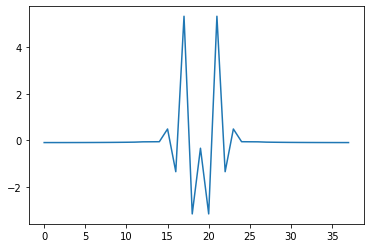

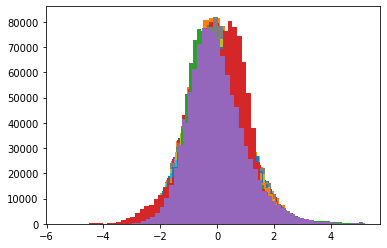

In [8]:
plt.plot(X[10000,:])
plt.show()
for i in range(15):
    plt.hist(Y[:,i],bins=50)
plt.show()

In [9]:
model = Sequential()

'''
model.add(Conv1D(filters = 30, kernel_size = 5, activation='relu', input_shape = (38,1)))
#model.add(BatchNormalization())
model.add(Conv1D(filters = 60, kernel_size = 5, activation='relu'))
#model.add(BatchNormalization())
#model.add(Conv1D(filters = 16, kernel_size = 3, activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool1D(strides=2))
model.add(Dropout(0.25))

#model.add(Conv1D(filters = 60, kernel_size = 5, activation='relu'))
#model.add(BatchNormalization())
#model.add(Conv1D(filters = 60, kernel_size = 5, activation='relu'))
#model.add(BatchNormalization())
#model.add(Conv1D(filters = 32, kernel_size = 3, activation='relu'))
#model.add(BatchNormalization())
#model.add(MaxPool1D(strides=2))
#model.add(Dropout(0.25))
'''

model.add(Flatten(input_shape=(38,1)))
model.add(Dense(760, activation='linear'))
model.add(LeakyReLU(alpha=.1))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(300, activation='linear'))
model.add(LeakyReLU(alpha=.1))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(15, activation='linear')) #tanh 
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 38)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 760)               29640     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 760)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 760)               3040      
_________________________________________________________________
dropout_1 (Dropout)          (None, 760)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 300)               228300    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 300)              

In [10]:
model.compile(loss='mse', optimizer = Adam(lr=1e-4), metrics=["accuracy"])

annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

hist = model.fit(x=xtrain, y=ytrain, batch_size=512,
                           epochs=4, 
                           verbose=1,  #1 for ETA, 0 for silent
                           validation_data=(xtest, ytest), #For speed
                           callbacks=[annealer])

Train on 945049 samples, validate on 105006 samples
Epoch 1/4
945049/945049 [==============================] - 73s 77us/step - loss: 0.6865 - accuracy: 0.2785 - val_loss: 0.5680 - val_accuracy: 0.3269
Epoch 2/4
945049/945049 [==============================] - 70s 74us/step - loss: 0.5726 - accuracy: 0.3284 - val_loss: 0.5410 - val_accuracy: 0.3449
Epoch 3/4
945049/945049 [==============================] - 69s 73us/step - loss: 0.5574 - accuracy: 0.3390 - val_loss: 0.5402 - val_accuracy: 0.3481
Epoch 4/4
945049/945049 [==============================] - 69s 73us/step - loss: 0.5497 - accuracy: 0.3452 - val_loss: 0.5300 - val_accuracy: 0.3596


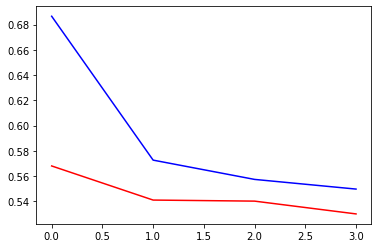

In [11]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()

In [12]:
Y_hat=model.predict(X)

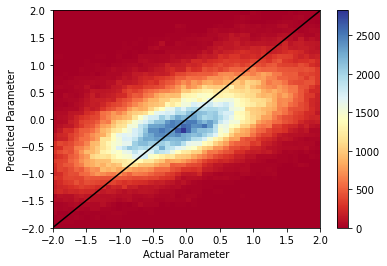

In [27]:

from matplotlib import cm

plt.hist2d(Y[:,0],Y_hat[:,0],bins=50,cmap=cm.RdYlBu,range=[[-2,2],[-2,2]])
plt.xlabel('Actual Parameter')
plt.ylabel('Predicted Parameter')
plt.colorbar()
plt.plot(np.arange(-2,2.1,0.1),np.arange(-2,2.1,0.1),c='k')
plt.show()

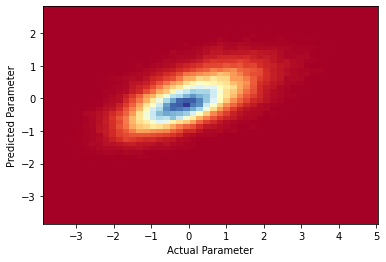

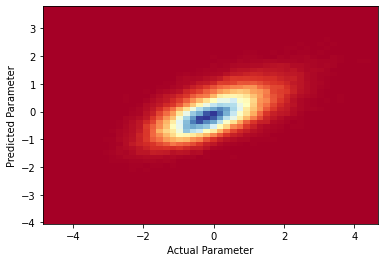

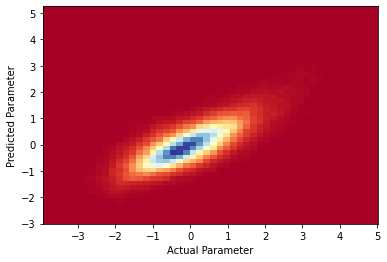

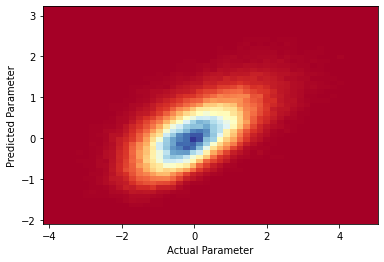

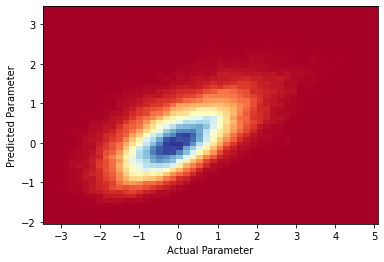

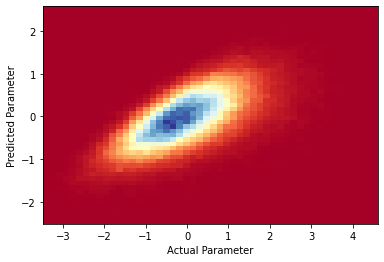

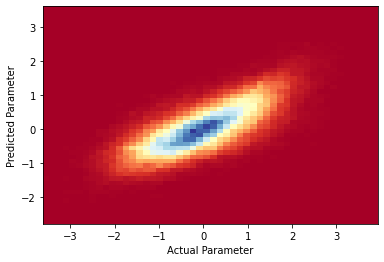

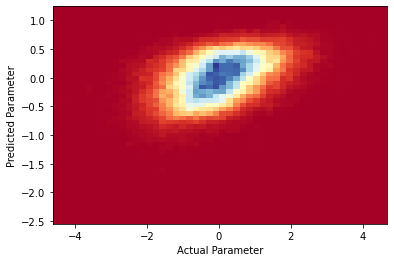

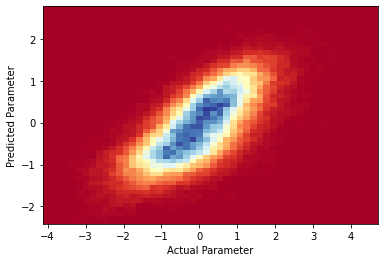

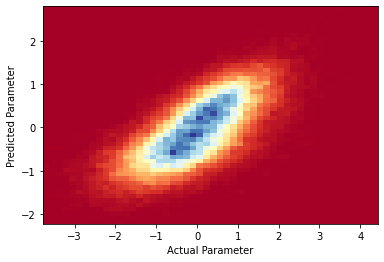

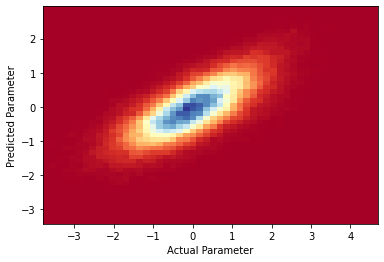

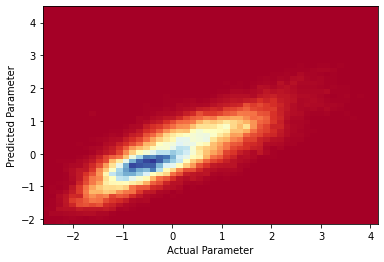

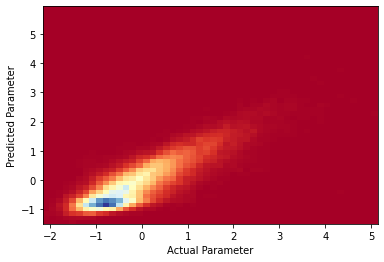

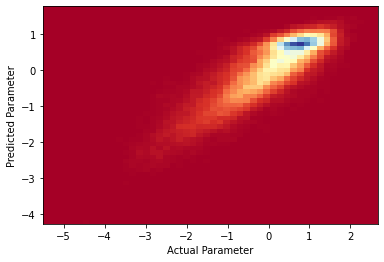

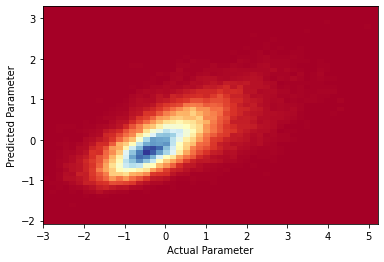

In [14]:
from matplotlib import cm

for i in range(15):
  plt.hist2d(Y[:,i],Y_hat[:,i],bins=50,cmap=cm.RdYlBu)
  plt.xlabel('Actual Parameter')
  plt.ylabel('Predicted Parameter')
  #plt.plot(np.arange(0,1,0.01),np.arange(0,1,0.01))
  plt.show()

In [15]:
from sklearn.metrics import r2_score 
for i in range(15):
  print(np.round(r2_score(Y[:,i], Y_hat[:,i]),3),end='\t')

0.37	0.385	0.569	0.352	0.352	0.404	0.531	0.183	0.472	0.469	0.525	0.64	0.677	0.682	0.427	

$R^2$ Error: \\
Cross-Section Data: \\
[0.334	0.368	0.537	0.361	0.361	0.382	0.489	0.154	0.466	0.458	0.491	0.601	0.637	0.649	0.396] \\
Cross-Section Data (Un-normalized): \\
[0.368	0.392	0.577	0.389	0.394	0.392	0.53	0.185	0.488	0.48	0.526	0.638	0.683	0.683	0.433] \\
FFT Data: \\
[0.353	0.372	0.538	0.349	0.377	0.387	0.492	0.158	0.465	0.456	0.499	0.602	0.649	0.658	0.4]	

In [16]:
Y_mean=np.mean(Y,axis=0)
np.round(1-np.sum((Y-Y_hat)**2,axis=0)/np.sum((Y-Y_mean)**2,axis=0),3)

array([0.37 , 0.386, 0.569, 0.352, 0.352, 0.404, 0.531, 0.183, 0.472,
       0.469, 0.525, 0.64 , 0.677, 0.682, 0.427], dtype=float32)